In [1]:
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from operator import xor
plt.rcParams['font.size'] = 14

In [2]:
CASE=1
if CASE==0: dname="DATA"
if CASE==1: dname="DATA_b"

fname=dname+'/x_RBM_q0.1.dat'
# loading data: each row is a list of visible units
# NOTE: data "x" here is named "v" for "visible"
v = np.loadtxt(fname, delimiter=" ",dtype=int)
# store in v0, because later we will shuffle v
v0 = np.copy(v)
# to start, take a small subsample
# v = v[1:11]
N = len(v)
L = len(v[1])
n_hot_encoding=4
n_chunk=int(L/n_hot_encoding)

SPINS = True
# SPINS = False

if SPINS:
    # sigmoid takes into account energy difference =2
    GAP=2
    v = 2*v - 1
    vmin=-1
    ONE_ONLY = True
    
else:
    GAP=1
    vmin=0
    ONE_ONLY = False

#print(f'each of N={N} data has L={L} digits')

#for i in range(min(12,N)):
#    if SPINS: print(v0[i],"\n->",v[i])
#    else: print(v[i])
#print('...')

## Inizialization

In [3]:
# RBM, nr of hidden units
if CASE==0: M = 3
if CASE==1: M = 6
# range of each initial weight
sigma = sqrt(4. / float(L + M))
# random seed for reproducibility
np.random.seed(12345)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(L,M)
w0 = np.copy(w)
a = sigma * np.random.randn(L)
aa = np.copy(a)
b = np.zeros(M)
#print("w=",w);print("a=",a);print("b=",b)
w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)

## Plotting

In [4]:
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    print(x)
    y=list(range(np))
    for i in range(np):
        y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)
(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(epoch=0):
    A=2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(w[i][j]))
    # Scatter plot on top of lines
    
    A=300./(a.max()+b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(b[j]), zorder=2, c=mycolor(b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()
    
def plotgraph(epoch=0):
    fig, ax = plt.subplots(1,1 , figsize=(10, 5))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=500.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.5,0.9,"hidden\nlayer")
    plt.show()
                  

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1]


In [5]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap DE=2 for "spin" variables (-1,1)
def activate(v_in,wei,bias,DE,info=False):
    act = np.dot(v_in, wei) + bias
    n = np.shape(act)
    prob = 1. / (1. + exp(-DE*act))
    v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's
    v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
    if info:
        print('input=', v_in)
        print('act=',act)
        print('prob=',prob)
        print('output=',v_out)
    return v_out

#### 4. Backward step of contrastive divergence that preserves the one-hot encoding structure.

In [6]:
def activate_backward(v_in,wei,bias,GAP):
    
    #function that implemets a CD backward step
    #output: fantasy data vf
    G=5
    A=4
    v = np.diag([1]*A)
    v[v==0] = vmin #So that it also works for SPINS==True
    act = np.dot(v_in, wei.T) + bias
    E = np.dot(v, act.reshape(G,A).T)
    E_sum = np.sum(E)
    Bi = np.exp(GAP * E)
    prob = Bi/np.sum(Bi, axis=0)
    prob_cum = np.cumsum(prob, axis=0)
    mask = np.argmax(prob_cum > np.random.rand(G), axis=0)
    v_out=v[mask, :].reshape(-1)
    return v_out, E_sum

## RBM train


In [7]:
def d(A, B): 
    rows=A.shape[0]
    min_vec=np.zeros((rows, 1))   
    if np.all(A==B):
        min_vec=np.zeros((rows, 1))
        for m in range(rows):
            A_br=np.tile(A[m], (rows-1, 1))
            B2=np.delete(B, m, 0)
            diff=xor(A_br, B2)
            sums=np.sum(diff, axis=1)
            min_vec[m]=np.min(sums)

    else:
        min_vec=np.zeros((rows, 1))
        for m in range(rows):
            A_br=np.tile(A[m], (rows, 1))
            diff=xor(A_br, B)
            sums=np.sum(diff, axis=1)
            min_vec[m]=np.min(sums)
    return min_vec

In [8]:
def accurracy(A,B):
    
    rows=A.shape[0]
    
    daa=d(A,A)
    dab=d(A,B)
    dbb=d(B,B)
    dba=d(B,A)
    dd_a=dab-daa
    dd_b=dba-dbb
    
    positive_a=np.sum(dd_a>0)
    zeros_a=np.sum((dd_a==0))*0.5
    dd_a_m=positive_a + zeros_a
    
    positive_b=np.sum(dd_b>0)
    zeros_b=np.sum((dd_b==0))*0.5
    dd_b_m=positive_b + zeros_b
    
    acc_A=dd_a_m/rows
    acc_B=dd_b_m/rows
    
    epsilon=(acc_A-0.5)**2+(acc_B-0.5)**2
    
    return epsilon, acc_A, acc_B

In [9]:
# np.sum(-np.matmul(v,a.T) - np.dot(b,h)*np.ones(np.shape(v)[0]) - np.dot(v,np.dot(w,h).T))

#### Normal

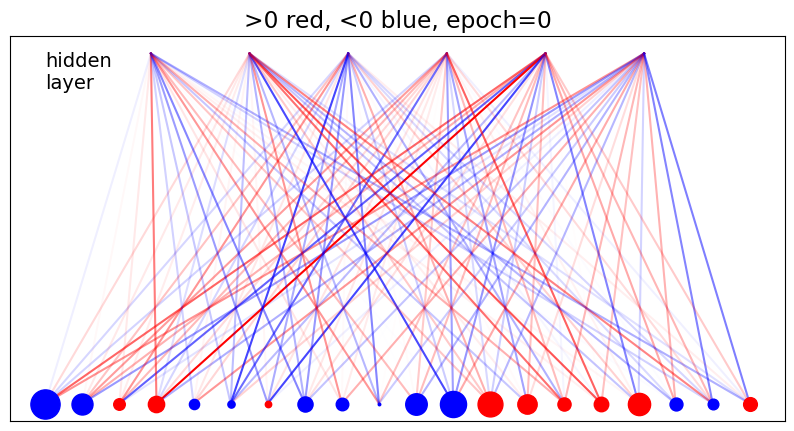

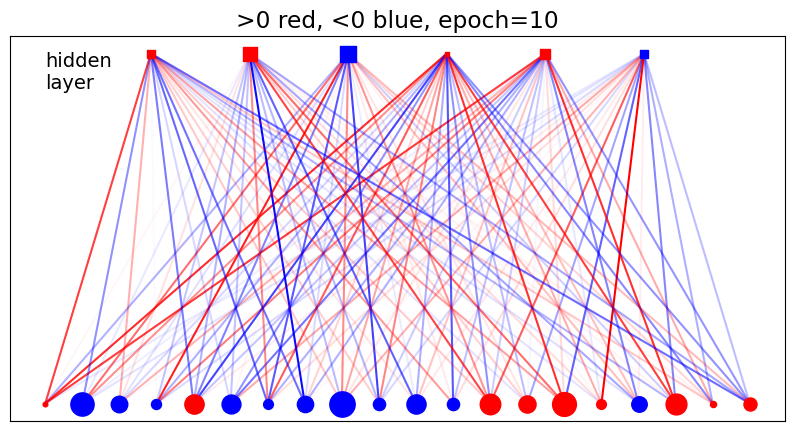

l_rate =  0.9090909090909092


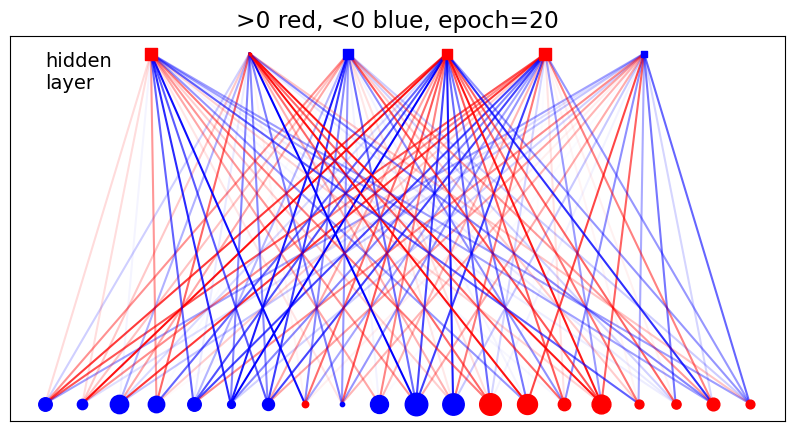

l_rate =  0.8333333333333337


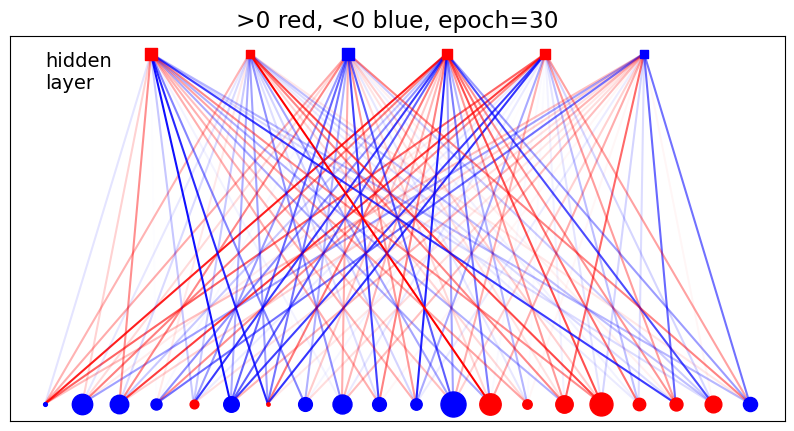

l_rate =  0.7692307692307697


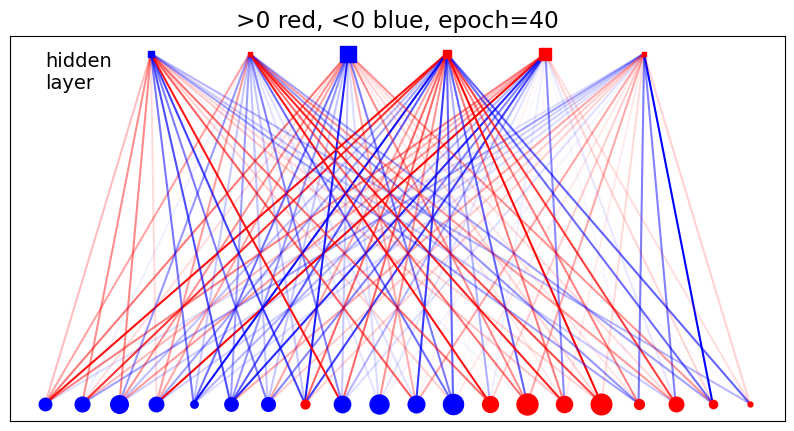

l_rate =  0.7142857142857149


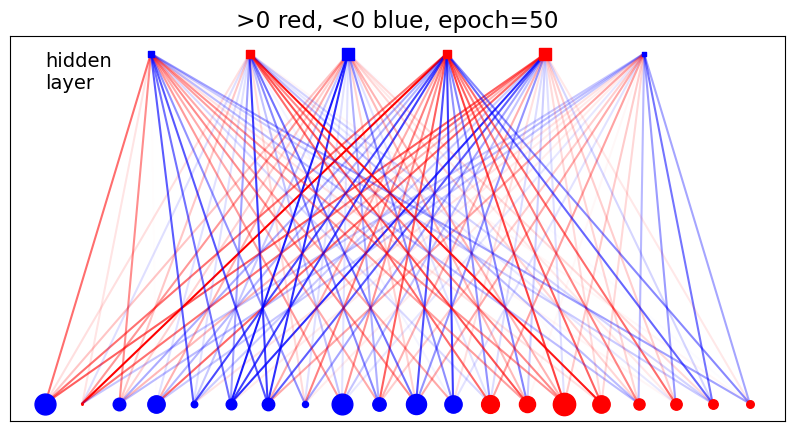

l_rate =  0.6666666666666671


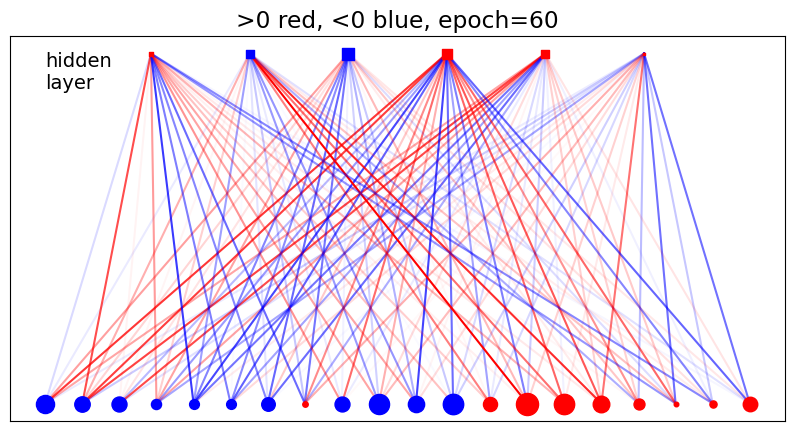

l_rate =  0.6250000000000006


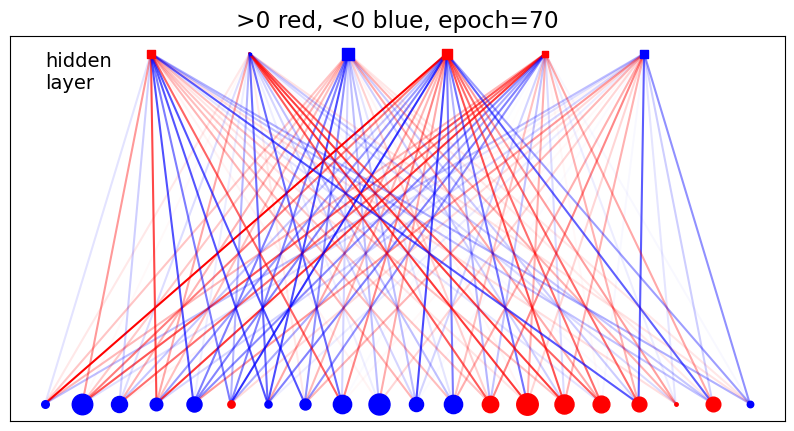

l_rate =  0.5882352941176475


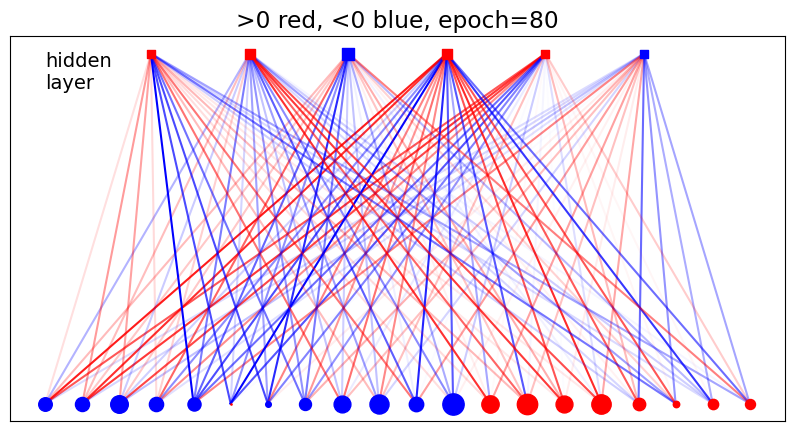

l_rate =  0.555555555555556


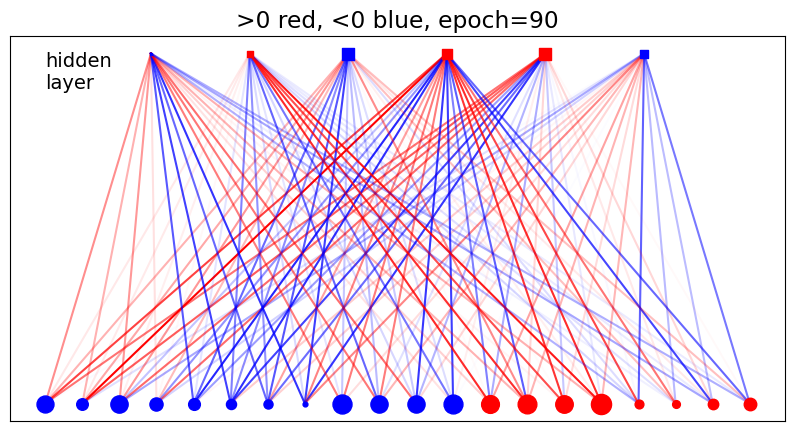

l_rate =  0.5263157894736847


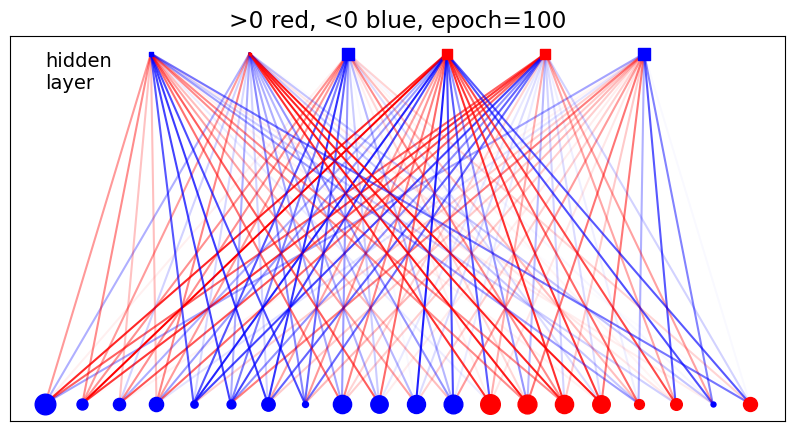

l_rate =  0.5000000000000009


In [10]:
# sketch for multiple CD, ADAM, RMS
# random seed for reproducibility
import math
np.random.seed(12345)

plotgraph(0)

# Input the parameters
opt = 1  #case 1 vanila, case 2 ADAM, case 3 RMSprop  
kk = 1  #number of CD steps

# learning rate
if opt == 1: 
    l_rate = 1
    ep = 100
if opt == 2: 
    l_rate = 1
    ep = 95
if opt ==3:
    l_rate = 1
    ep = 100

# minibatch
mini, m = 500, 0

# RMSprop hyperparameters
beta = 0.9
eps = 1e-8


# ADAM hyperparameters
beta1 = 0.9
beta2 = 0.99


#E_tot = np.zeros(ep)
#Acc_tot = []
#E_data = 0
#E0 = np.zeros(ep)
# train model
print('===================================================')

for epoch in range(ep):
    # aggregate normalization of batch statistics and learning rate
#     E_tot_m = []
    l_rate_m = l_rate / mini
#    E_tot_mini = np.zeros(N)
#    Acc_tot_mini = []
    vff = np.zeros_like(v0)

    for k in range(N):
        if m==0:
#             E_tot_mini = []
            
            # initialize averages in miniblock
            v_data, v_model = np.zeros(L),np.zeros(L)
            h_data, h_model = np.zeros(M),np.zeros(M)
            vh_data,vh_model= np.zeros((L,M)),np.zeros((L,M))
            
            m_w,v_w,m_w_hat, v_w_hat = np.zeros((L,M)), np.zeros((L,M)), np.zeros((L,M)), np.zeros((L,M))
            m_a,v_a,m_a_hat, v_a_hat = np.zeros(L),np.zeros(L),np.zeros(L),np.zeros(L)
            m_b,v_b,m_b_hat, v_b_hat = np.zeros(M),np.zeros(M),np.zeros(M),np.zeros(M)
            
            aa = np.abs(a*0)
            bb = np.abs(b*0)
            ww = np.abs(w*0)
            
            
#             vd = []
#             vfant = []
            

        # positive CD phase: generating h 
        h = activate(v[k],w,b,GAP)
        
        
        vf, E_sum = activate_backward(h, w, a, GAP) #<- new way
#         E_tot_mini[k] = -(E_sum +  np.dot(b,h))
        
#        if  (k==0):
#            E0[epoch] = -np.dot(v[0].T, np.dot(w, h)) - np.dot(a, v[0]) - np.dot(b, h)
#             temp = np.copy(v)
#             temp[temp==-1]=0
#             E_data = -np.dot(temp,a.T) - np.dot(temp,np.dot(w,h).T)
#             E_data = np.sum(-np.matmul(temp,a.T) - np.dot(b,h)*np.ones(np.shape(temp)[0]) - np.dot(temp,np.dot(w,h).T))
#             E_data = np.mean(-np.matmul(temp,a.T) - np.dot(b,h)*np.ones(np.shape(temp)[0]) - np.dot(temp,np.dot(w,h).T))
#             h_lat = h
        
        # negative CD phase: generating fantasy vf
        #vf = activate(h,w.T,a,GAP)

#         vf, E_avg = activate_backward(h, w, a, GAP) #<- new way
        

        # one more positive CD phase: generating fantasy h from fantasy vf 
        hf = activate(vf,w,b,GAP)
            
        if kk != 1: 
            for kk in range(kk-1):
                # negative CD phase: generating fantasy vf
                #vf = activate(hf,w.T,a,GAP)
                vf,_ = activate_backward(hf, w, a, GAP)
                # one more positive CD phase: generating fantasy h from fantasy vf 
                hf = activate(vf,w,b,GAP)
                
#                 E_tot_mini[k] = -np.dot(vf.T, np.dot(w, h)) - np.dot(a, vf) - np.dot(b, h)
#         else:
#                 E_tot_mini[k] = -np.dot(v[k].T, np.dot(w, h)) - np.dot(a, v[k]) - np.dot(b, h)

 #       E_tot_mini[k] = -np.dot(vf.T, np.dot(w, h)) - np.dot(a, vf) - np.dot(b, h)
            
            
        v_data  += v[k]
        v_model += vf
        h_data  += h
        h_model += hf
        vh_data += np.outer(v[k].T,h)
        vh_model+= np.outer(vf.T,hf)
        vff[k] = vf
        

        
#         tt = np.copy(vf)
#         tt[tt==-1]=0
#         E_tot_mini.append(-np.dot(a,vf) - np.dot(b,hf) - np.dot(vf,np.dot(w,hf).T))
#         E_tot_mini.append(-np.dot(a,tt) - np.dot(b,hf) - np.dot(tt,np.dot(w,hf).T))
#         E_tot_mini.append(np.sum(-np.matmul(tt,a.T) - np.dot(b,h)*np.ones(np.shape(tt)[0]) - np.dot(tt,np.dot(w,h).T)))
#         Acc_tot_mini.append(accurracy(v0[k],vf))

       
        m += 1
        # minibatch
        if m==mini:       
#                 E_tot_m.append(np.mean(E_tot_mini))
#                 eps,_,_ = accurracy(((vd.reshape(mini,L)).astype(int)),((vfant.reshape(mini,L)).astype(int)))
#                 Acc_tot_mini.append(eps)
                if opt == 1 : 
                    dw = l_rate_m*(vh_data - vh_model)
                    da = l_rate_m*(v_data - v_model)
                    db = l_rate_m*(h_data - h_model)
                    # basic step of vanilla gradient descent, from eq.(211)
                    w = w + dw
                    a = a + da
                    b = b + db
                    m = 0
                
                #for ADAM
                if opt == 2: 
                    dw = (vh_data - vh_model)
                    da = (v_data - v_model)
                    db = (h_data - h_model)
                    
                    m_w = beta1*m_w + (1 - beta1)*dw
                    m_a = beta1*m_a + (1 - beta1)*da
                    m_b = beta1*m_b + (1 - beta1)*db

                    v_w = beta2*v_w + (1 - beta2)*(dw**2)
                    v_a = beta2*v_a + (1 - beta2)*(da**2)
                    v_b = beta2*v_b + (1 - beta2)*(db**2)
                    
                    m_w_hat = m_w/(1 - np.power(beta1, m))
                    m_a_hat = m_a/(1 - np.power(beta1, m))
                    m_b_hat = m_b/(1 - np.power(beta1, m))
                    
                    v_w_hat = v_w/(1 - np.power(beta2, m))
                    v_a_hat = v_a/(1 - np.power(beta2, m))
                    v_b_hat = v_b/(1 - np.power(beta2, m))
                    
                    w += l_rate_m*m_w_hat/(np.sqrt(v_w_hat + eps))
                    a += l_rate_m*m_a_hat/(np.sqrt(v_a_hat + eps))
                    b += l_rate_m*m_b_hat/(np.sqrt(v_b_hat + eps))
                    m = 0

                #for RMSprop
                if opt ==3:
                    dw = (vh_data - vh_model)
                    da = (v_data - v_model)
                    db = (h_data - h_model)
                    
                    ww = beta*ww + (1 - beta)*np.square(dw)
                    aa = beta*aa + (1 - beta)*np.square(da)
                    bb = beta*bb + (1 - beta)*np.square(db) 
                    
                    w += (l_rate_m*dw)/(np.sqrt(ww + eps))
                    a += (l_rate_m*da)/(np.sqrt(aa + eps))
                    b += (l_rate_m*db)/(np.sqrt(bb + eps))
                    m = 0
       
                     
    # randomize the order of input data
    np.random.shuffle(v)
    
    # decrease the learning rate (here as a power law) only for vanilla GD
    l_rate = l_rate / (0.01 * l_rate + 1)
    
 #   E_tot[epoch] = np.mean(E_tot_mini)
 
    
    vff[vff==-1]=0
#    eps,_,_ = accurracy(v0[9000:9999],vff[9000:9999])

#     E_tot.append(np.mean(-np.matmul(vff,a.T) - np.dot(b,h)*np.ones(np.shape(vff)[0]) - np.dot(vff,np.dot(w,h).T)))
#    Acc_tot.append(eps)
    
#     Acc_tot.append(np.mean(Acc_tot_mini))

    if epoch%10==9:
        plotgraph(epoch+1)
        print('l_rate = ',l_rate)
    
    
                

In [16]:
print(vff.shape)

(10000, 20)


In [17]:
# plt.plot(E_tot_mini)

In [18]:
# print(E_data)
# print((E_tot))
# print(len((E_tot_m)))
#plt.plot(np.abs(E_tot))


# print(E_data)
# E_dat = np.mean(-np.matmul(tt,aa.T) - np.dot(tt,np.dot(w0,h_lat).T))
# print(E_data)
# plt.hlines(np.sum(E_data), 0,ep)
# plt.hlines(np.abs(np.mean(E0)), 0,ep)
#plt.hlines(np.abs(np.mean(E0)),0,ep)
#print(E0)

In [20]:
#  print(Acc_tot)

#plt.plot(Acc_tot[0::])
#plt.yscale('log')
# plt.hlines(0.5, 0,ep)

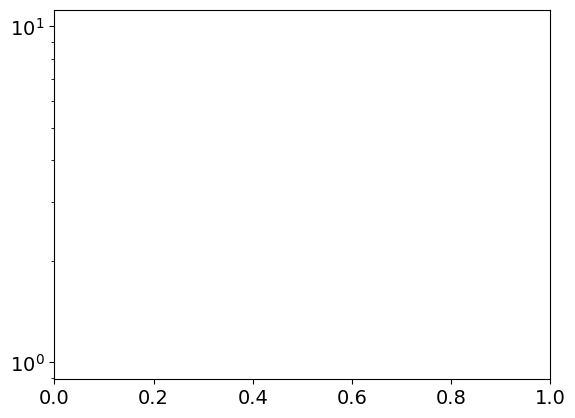

In [21]:
plt.yscale('log')

In [22]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2))

EE = np.mean(np.abs(E0))
Ea = np.ones_like(E_tot)*(np.mean(E0))

plt.plot(rmse((E_tot),Ea))

NameError: name 'E_tot' is not defined

#### With centering trick:

In [23]:
# # RBM, nr of hidden units
# if CASE==0: M = 3
# if CASE==1: M = 6
# # range of each initial weight
# sigma = sqrt(4. / float(L + M))
# # random seed for reproducibility
# np.random.seed(12345)
# # initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
# w = sigma * np.random.randn(L,M)
# a = sigma * np.random.randn(L)
# b = np.zeros(M)
# #print("w=",w);print("a=",a);print("b=",b)
# w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)

In [24]:
# # sketch for multiple CD, ADAM, RMS
# # random seed for reproducibility
# np.random.seed(12345)

# plotgraph(0)

# # Input the parameters
# opt = 1  #case 1 vanila, case 2 ADAM, case 3 RMSprop  
# kk = 1  #number of CD steps

# # learning rate
# if opt == 1: 
#     l_rate = 1
#     ep = 100
# if opt == 2: 
#     l_rate = 1
#     ep = 95
# if opt ==3:
#     l_rate = 1
#     ep = 50

# # minibatch
# mini, m = 500, 0

# # RMSprop hyperparameters
# beta = 0.9
# eps = 1e-8


# # ADAM hyperparameters
# beta1 = 0.9
# beta2 = 0.99

# #central trick parameters
# psi_mu = 0.01
# psi_lam = 0.01
# mu = np.zeros(L)
# lam = np.zeros(M)

# # train model
# print('===================================================')
# E_tot = []
# E_data = 0
# for epoch in range(ep):
#     # aggregate normalization of batch statistics and learning rate
#     E_tot_m = []
#     E_tot_mini = []
#     l_rate_m = l_rate/mini
#     batch_group=1
#     for k in range(N):
#         if m==0:
#             # centering trick
#             # initialize averages in miniblock
#             v_data, v_model= np.zeros((N,L)),np.zeros((N,L))
#             h_data, h_model= np.zeros((N,M)),np.zeros((N,M))
            
#             # initialize adam and rms parameters for every minibatch
#                 # adam
#             aa = np.abs(a*0)
#             bb = np.abs(b*0)
#             ww = np.abs(w*0)
#                 # rms
#             m_w,v_w,m_w_hat, v_w_hat = np.zeros((L,M)), np.zeros((L,M)), np.zeros((L,M)), np.zeros((L,M))
#             m_a,v_a,m_a_hat, v_a_hat = np.zeros(L),np.zeros(L),np.zeros(L),np.zeros(L)
#             m_b,v_b,m_b_hat, v_b_hat = np.zeros(M),np.zeros(M),np.zeros(M),np.zeros(M)
            
#         # positive CD phase: generating h 
#         h = activate(v[k],w,b,GAP)
        
#         if (epoch==1 and k==1):
#             E_data = -np.dot(a,v[1]) - np.dot(b,h) - np.dot(v[1],np.dot(w,h).T)
        
#         # negative CD phase: generating fantasy vf
#         #vf = activate(h,w.T,a,GAP)
#         vf = activate_backward(h, w, a, GAP) #<- new way
        
#         # one more positive CD phase: generating fantasy h from fantasy vf 
#         hf = activate(vf,w,b,GAP)
            
#         if kk != 1: 
#             for kk in range(kk-1):
#                 # negative CD phase: generating fantasy vf
#                 #vf = activate(hf,w.T,a,GAP)
#                 vf = activate_backward(hf, w, a, GAP)
                    
#                 # one more positive CD phase: generating fantasy h from fantasy vf 
#                 hf = activate(vf,w,b,GAP)

        
#         v_data[k]= v[k]
#         v_model[k]= vf
#         h_data[k]= h
#         h_model[k]= hf
#         E_tot_mini.append(-np.dot(a,vf) - np.dot(b,hf) - np.dot(vf,np.dot(w,hf).T))
       
        
#         m += 1
#         # minibatch
#         if m==mini:
#             E_tot_m.append(np.mean(E_tot_mini))

#             v_data_bg = v_data[(batch_group-1)*mini:batch_group*mini,:]
#             v_model_bg = v_model[(batch_group-1)*mini:batch_group*mini,:]
#             h_data_bg = h_data[(batch_group-1)*mini:batch_group*mini,:]                           
#             h_model_bg = h_model[(batch_group-1)*mini:batch_group*mini,:]       
            
#             #estimate mu_batch and lambda_batch
#             mu_batch = np.mean(v_data_bg, axis=0)
#             lam_batch = np.mean(h_data_bg, axis=0)
            
#             #Transform the parameters with respect to the new offsets
#             a = a + psi_lam*np.dot(w,(lam_batch-lam))
#             b = b + psi_mu*np.dot(w.T,(mu_batch-mu))
            
#             #Update the offsets using a moving average with factors psi_mu and psi_lam
#             mu = (1-psi_mu)*mu + psi_mu*mu_batch
#             lam = (1-psi_lam)*lam + psi_lam*lam_batch
           
            
#             v_data = np.sum(v_data_bg, axis=0)
#             v_model = np.sum(v_model_bg, axis=0)
#             h_data = np.sum(h_data_bg, axis=0)                              
#             h_model = np.sum(h_model_bg, axis=0)
            
#             vh_data = np.dot((v_data_bg-mu).T,(h_data_bg-lam))
#             vh_model = np.dot((v_model_bg-mu).T,(h_model_bg-lam))
            
            
#             #Update the parameters according to the gradients
#             #case 1 vanila, case 2 ADAM, case RMSprop                    
#             if opt == 1 : 
#                 dw = l_rate_m*(vh_data - vh_model)
#                 da = l_rate_m*(v_data - v_model)
#                 db = l_rate_m*(h_data - h_model)
#                 # basic step of vanilla gradient descent, from eq.(211)
#                 w = w + dw
#                 a = a + da
#                 b = b + db
#                 m = 0

                
#             #for ADAM
#             if opt == 2: 
#                 dw = (vh_data - vh_model)
#                 da = (v_data - v_model)
#                 db = (h_data - h_model)

#                 m_w = beta1*m_w + (1 - beta1)*dw
#                 m_a = beta1*m_a + (1 - beta1)*da
#                 m_b = beta1*m_b + (1 - beta1)*db

#                 v_w = beta2*v_w + (1 - beta2)*(dw**2)
#                 v_a = beta2*v_a + (1 - beta2)*(da**2)
#                 v_b = beta2*v_b + (1 - beta2)*(db**2)

#                 m_w_hat = m_w/(1 - np.power(beta1, m))
#                 m_a_hat = m_a/(1 - np.power(beta1, m))
#                 m_b_hat = m_b/(1 - np.power(beta1, m))

#                 v_w_hat = v_w/(1 - np.power(beta2, m))
#                 v_a_hat = v_a/(1 - np.power(beta2, m))
#                 v_b_hat = v_b/(1 - np.power(beta2, m))

#                 w += l_rate_m*m_w_hat/(np.sqrt(v_w_hat + eps))
#                 a += l_rate_m*m_a_hat/(np.sqrt(v_a_hat + eps))
#                 b += l_rate_m*m_b_hat/(np.sqrt(v_b_hat + eps))
#                 m = 0                    


#             #for RMSprop
#             if opt ==3:
#                 dw = (vh_data - vh_model)
#                 da = (v_data - v_model)
#                 db = (h_data - h_model)

#                 ww = beta*ww + (1 - beta)*np.square(dw)
#                 aa = beta*aa + (1 - beta)*np.square(da)
#                 bb = beta*bb + (1 - beta)*np.square(db) 

#                 w += (l_rate_m*dw)/(np.sqrt(ww + eps))
#                 a += (l_rate_m*da)/(np.sqrt(aa + eps))
#                 b += (l_rate_m*db)/(np.sqrt(bb + eps))
#                 m = 0

                
#     # randomize the order of input data
#     np.random.shuffle(v)
    
#     # decrease the learning rate (here as a power law)
#     l_rate = l_rate / (0.01 * l_rate + 1)
#     E_tot.append(np.mean(E_tot_mini))

#     if epoch%10==9:
#         plotgraph(epoch+1)
#         print('l_rate = ',l_rate)
                

In [25]:
# print(E_data)
# # print((E_tot))
# print(len((E_tot_m)))
# plt.plot(np.abs(E_tot))
# plt.hlines(np.mean(np.abs(E_data)), 0,ep)

In [26]:
#print('w0=',w0);print('a0=',a0);print('b0=',b0)
#print('w=',w);print('a=',a);print('b=',b)

#### 5. Weights $w_{iμ}$ of each hidden unit μ in an A×G table, red means positive and blue means negative weight.

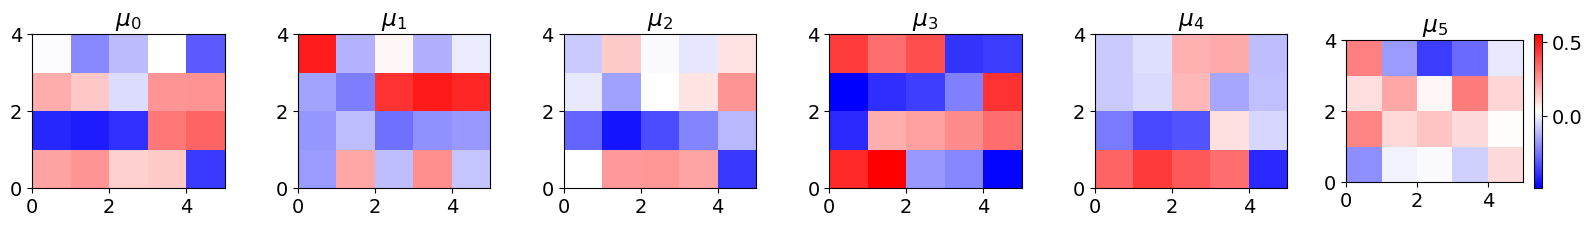

In [27]:
fig, ax = plt.subplots(1,M, figsize=(20,2) )
# for every hidden variable (column of W)
for mu in range(M):
# I select the corresponding weights (in the mu-th column of the W matrix) and reshape it to achieve a rectangular shape
# of (A=n_hot_encoding,G=n_chunks)
    temp=np.reshape(w[:,mu],(n_hot_encoding,n_chunk))
# and then plot the result
    ydim,xdim= temp.shape
    x=np.arange(xdim+1) ; y=np.arange(ydim+1)
    ecia = ax[mu].pcolormesh(x, y, temp, shading='flat', vmin=w.min(), vmax=w.max(), cmap='bwr')
    ax[mu].set_title("$\mu_"+str(mu)+"$")
    ax[mu].set_aspect('equal')
fig.colorbar(ecia)

## Test: Decostruction

In [28]:
from IPython.display import display_html 
import pandas as pd

ampl=1

# original, non-reshuffled data in v0
v1 = np.zeros_like(v0)

for k in range(N): #ORIGINALLY HERE WAS N, not 20
     
    # positive CD phase: generating h 
    h = activate(v0[k],w,b,ampl*GAP)
    
    # negative CD phase: generating fantasy vf with low T == large GAP
    #v1[k] = activate(h,w.T,a,ampl*GAP)
    v1[k] = activate_backward(h, w, a, ampl*GAP)
    
# difference between fantasy and data
diff = (v1 - v0)/2
str0 = fname+'_M'+str(M)+'-mini'+str(mini)
np.savetxt(str0+".fantasy", (v1+1)/2, fmt='%d',delimiter=' ')  
np.savetxt(str0+'.diff', diff, fmt='%d',delimiter=' ')  


def is_one(cell_value):
    color0 = 'background-color: gray; color: white'
    color1 = 'background-color: gold;'
    if type(cell_value) in [float, int]:
        if cell_value == 1:
            return color1
    return color0

N1=20
df0 = pd.DataFrame(v0[:N1])
df1 = pd.DataFrame(((v1[:N1]-vmin)/(1-vmin)).astype(int))

df0s = df0.style.set_table_attributes("style='display:inline'")
df1s = df1.style.set_table_attributes("style='display:inline'")
df0s.applymap(is_one)
df1s.applymap(is_one)
sty = [dict(selector="caption",props=[("font-size", "150%")])]
df0s.set_caption('Original').set_table_styles(sty)
df1s.set_caption('Deconstructed').set_table_styles(sty)

display_html(df0s._repr_html_()+df1s._repr_html_(), raw=True)

ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 1.

In [ ]:
v1[v1==-1]=0

In [ ]:
#accurracy(v0,v1) #vanilla #mini=500 #kk=1 #no center